## Tensorflow 2.x Setup


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import random
import numpy as np
import math
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
print(tf.__version__)

# pytorch
import torch
from torch import nn
print(torch.__version__)

# scikit-learn
import sklearn
from sklearn import cluster, decomposition, manifold, metrics
import pandas as pd
import seaborn as sns

import scipy
from scipy.stats import entropy
from scipy.stats import dirichlet
import ast

!pip install tikzplotlib
import tikzplotlib

# access google file system
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/'
data_dir = cwd + 'Mem_Att_RNN/data/'
dir = cwd + 'Mem_Att_RNN/plots/'

Found GPU at: /device:GPU:0
2.8.2
1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.0 MB/s 
Mounted at /content/drive


In [ ]:
# shadow model (seed 1~10)
# IN: label_1 ... label_10
# OUT: label_11 ... label_20

# attack model
# attack( concat(value_traj_5, rewards_to_go_5) ) = IN
# attack( concat(value_traj_15, rewards_to_go_15) ) = OUT

# victim, whether seed 3 is used in training the target model
# attack( concat(value_traj_3, rewards_to_go_3) ) ==> IN/OUT

In [ ]:
def concat_data(dataframe, pad_len=64):
    # reshape the data into the shape that fit the attack model
    data = []
    for i in list(dataframe.index):
        val_traj = ast.literal_eval(dataframe['value'][i])
        rew_traj = ast.literal_eval(dataframe['reward'][i])
        if len(val_traj) < pad_len:
            val_traj = np.pad(val_traj, (pad_len-len(val_traj), 0), 
                              'constant', constant_values=(0, 0))
            rew_traj = np.pad(rew_traj, (pad_len-len(rew_traj), 0), 
                              'constant', constant_values=(0, 0))
        data.append(np.concatenate([val_traj[-pad_len:], rew_traj[-pad_len:]]))
    return np.array(data)

def get_label_vector(labels):
    # Convert labels into vector form (one-hot embedding)
    label_vectors = np.zeros((len(labels), np.max(labels)+1))
    for i in range(len(labels)):
        label_vectors[i, labels[i]] = 1
    return label_vectors

def get_att_data(data, label):
    labels = get_label_vector(label)
    c = list(zip(data, labels))
    random.shuffle(c)
    data, labels = zip(*c)
    return np.array(data), np.array(labels)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Softmax, LSTM
def build_att():
    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2))
    model.add(Softmax())
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    precision = keras.metrics.Precision(class_id=0)
    recall = keras.metrics.Recall(class_id=0)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', precision, recall])
    return model

### Get critic trajectories and concatenate values and rewards-to-go

In [ ]:
df = pd.read_csv(data_dir+'mr_def/critic_traj.csv')
target_df = pd.read_csv(data_dir+'mr_def_v/critic_traj.csv')
df.head()

,value,reward,env,label,corr
0,"[0.163, 0.188, 0.137, 0.137, 0.323, 0.323, 0.3...","[0.005, 0.008, 0.014, 0.022, 0.015, 0.008, 0.0...",MiniGrid-MultiRoom-N2-v0,1,0.684828
1,"[0.173, 0.18, 0.18, 0.173, 0.18, 0.173, 0.173,...","[0.0, 0.004, 0.008, 0.012, 0.015, 0.019, 0.024...",MiniGrid-MultiRoom-N2-v0,1,0.699047
2,"[0.525, 0.6, 0.334, 0.183, 0.131, 0.131, 0.131...","[0.089, 0.066, 0.058, 0.063, 0.071, 0.08, 0.08...",MiniGrid-MultiRoom-N2-v0,1,0.552074
3,"[0.469, 0.568, 0.208, 0.203, 0.151, 0.151, 0.1...","[0.043, 0.019, 0.022, 0.024, 0.032, 0.038, 0.0...",MiniGrid-MultiRoom-N2-v0,1,0.612753
4,"[0.083, 0.11, 0.11, 0.348, 0.074, 0.093, 0.074...","[0.025, 0.029, 0.034, 0.022, 0.029, 0.034, 0.0...",MiniGrid-MultiRoom-N2-v0,1,0.721514


## Unprotected

### Correlation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[1.       0.814607]
 [0.814607 1.      ]]


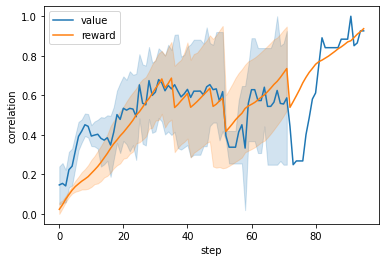

In [ ]:
v = []
r = []
x = []

for i in range(10):
    v += ast.literal_eval(df['value'][i])
    r += ast.literal_eval(df['reward'][i])
    x += range(len(ast.literal_eval(df['value'][i])))

sns.lineplot(x, v, label='value')
ax = sns.lineplot(x, r, label='reward')
ax.set_xlabel('step')
ax.set_ylabel('correlation')
print(np.corrcoef(np.array(v), np.array(r)))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[1.         0.58696673]
 [0.58696673 1.        ]]


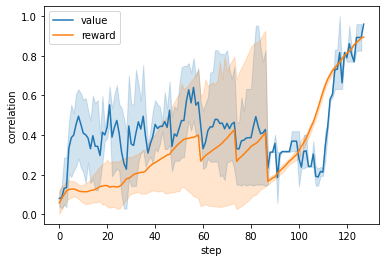

In [ ]:
v = []
r = []
x = []

for i in range(1210, 1215):
    v += ast.literal_eval(df['value'][i])
    r += ast.literal_eval(df['reward'][i])
    x += range(len(ast.literal_eval(df['value'][i])))

sns.lineplot(x, v, label='value')
ax = sns.lineplot(x, r, label='reward')
ax.set_xlabel('step')
ax.set_ylabel('correlation')
print(np.corrcoef(np.array(v), np.array(r)))

### Prepare data

In [ ]:
data = concat_data(df)
label = df['label'].to_numpy()
data.shape, label.shape

((2000, 128), (2000,))

In [ ]:
data, labels = get_att_data(data, label)

v_data = concat_data(target_df)
v_label = target_df['label'].to_numpy()
v_data, v_labels = get_att_data(v_data, v_label)

v_data.shape, v_labels.shape

((2000, 128), (2000, 2))

### Attack Model

In [ ]:
attack_model = build_att()
attack_model.fit(x=data, y=labels, batch_size=64, epochs=15, verbose=False)
attack_model.evaluate(x=v_data, y=v_labels, batch_size=64)

32/32 [==============================] - 1s 4ms/step - loss: 0.6707 - accuracy: 0.5840 - precision_9: 0.5608 - recall_9: 0.7750


[0.6706653833389282,
 0.5839999914169312,
 0.5607814788818359,
 0.7749999761581421]

### Environment-based inference

In [ ]:
votes = []
corrs = []
preds = []
actus = []

# for env, d in df.groupby('env'):
#     for i in range(0, len(d), len(d)//2):
#         env_data = concat_data(d[i:i+len(d)//2])
#         env_label = np.max(d[i:i+len(d)//2]['label'].to_numpy())
#         pred = np.argmax(attack_model.predict(env_data) , 1)
#         pred_label = 'in' if np.sum(pred) > len(d)/4 else 'out'
#         actu_label = 'in' if env_label==1 else 'out'
#         votes.append(np.sum(pred))
#         corrs.append(np.mean(d['corr'].to_numpy()))
#         preds.append(pred_label=='in')
#         actus.append(actu_label=='in')
#         print('prediction: ', pred_label, 'actual: ', actu_label, 'correct: ', pred_label==actu_label)  

print()
for env, d in target_df.groupby('env'):
    for i in range(0, len(d), len(d)//2):
        env_data = concat_data(d[i:i+len(d)//2])
        env_label = np.max(d[i:i+len(d)//2]['label'].to_numpy())
        pred = np.argmax(attack_model.predict(env_data) , 1)
        pred_label = 'in' if np.sum(pred) > len(d)/4 else 'out'
        actu_label = 'in' if env_label==1 else 'out'
        votes.append(np.sum(pred))
        corrs.append(np.mean(d['corr'][i:i+len(d)//2].to_numpy()))
        preds.append(pred_label=='in')
        actus.append(actu_label=='in')
        print('prediction: ', pred_label, 'actual: ', actu_label, 'correct: ', pred_label==actu_label)  


prediction:  in actual:  in correct:  True
prediction:  out actual:  in correct:  False
prediction:  out actual:  in correct:  False
prediction:  out actual:  in correct:  False
prediction:  out actual:  out correct:  True
prediction:  in actual:  out correct:  False
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  in actual:  out correct:  False
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:

In [ ]:
corrs, votes, preds, actus = np.array(corrs), np.array(votes), np.array(preds), np.array(actus)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

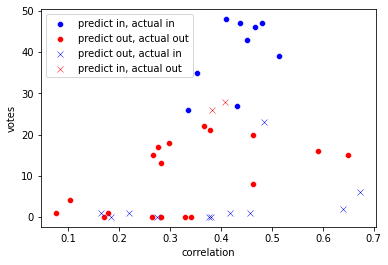

In [ ]:
idx = np.array([preds[i]==True and actus[i]==True for i in range(len(preds))])
ax = sns.scatterplot(corrs[idx], votes[idx], color='blue', label='predict in, actual in')

idx = np.array([preds[i]==False and actus[i]==False for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], ax=ax, color='red', label='predict out, actual out')

idx = np.array([preds[i]==False and actus[i]==True for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], ax=ax, color='blue', marker='x', label='predict out, actual in')

idx = np.array([preds[i]==True and actus[i]==False for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], ax=ax, color='red', marker='x', label='predict in, actual out')

ax.set_xlabel('correlation')
ax.set_ylabel('votes')
tikzplotlib.save(dir+"nn_def_gae.tex")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

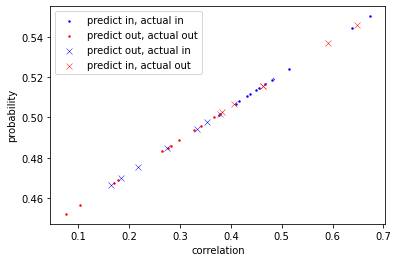

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(np.expand_dims(corrs, 1), actus)
preds = clf.predict(np.expand_dims(corrs, 1))
func = clf.predict_proba(np.expand_dims(corrs, 1))[:, 1]

idx = np.array([preds[i]==True and actus[i]==True for i in range(len(preds))])
ax = sns.scatterplot(corrs[idx], func[idx], color='blue', marker='.', label='predict in, actual in')

idx = np.array([preds[i]==False and actus[i]==False for i in range(len(preds))])
sns.scatterplot(corrs[idx], func[idx], ax=ax, color='red', marker='.', label='predict out, actual out')

idx = np.array([preds[i]==False and actus[i]==True for i in range(len(preds))])
sns.scatterplot(corrs[idx], func[idx], ax=ax, color='blue', marker='x', label='predict out, actual in')

idx = np.array([preds[i]==True and actus[i]==False for i in range(len(preds))])
ax = sns.scatterplot(corrs[idx], func[idx], ax=ax, color='red', marker='x', label='predict in, actual out')

# sns.lineplot(corrs, func, ax=ax, linestyle=':')
ax.set_xlabel('correlation')
ax.set_ylabel('probability')
tikzplotlib.save(dir+"log_def_gae.tex")

## Protected

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[1.         0.30167582]
 [0.30167582 1.        ]]


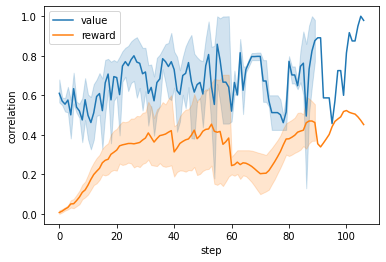

In [ ]:
v = []
r = []
x = []

for i in range(10):
    v += ast.literal_eval(df['value'][i])
    r += ast.literal_eval(df['reward'][i])
    x += range(len(ast.literal_eval(df['value'][i])))

sns.lineplot(x, v, label='value')
ax = sns.lineplot(x, r, label='reward')
ax.set_xlabel('step')
ax.set_ylabel('correlation')
print(np.corrcoef(np.array(v), np.array(r)))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[1.         0.30988668]
 [0.30988668 1.        ]]


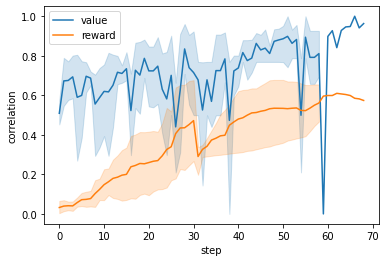

In [ ]:
v = []
r = []
x = []

for i in range(1010, 1015):
    v += ast.literal_eval(df['value'][i])
    r += ast.literal_eval(df['reward'][i])
    x += range(len(ast.literal_eval(df['value'][i])))

sns.lineplot(x, v, label='value')
ax = sns.lineplot(x, r, label='reward')
ax.set_xlabel('step')
ax.set_ylabel('correlation')
print(np.corrcoef(np.array(v), np.array(r)))

In [ ]:
data = concat_data(df)
label = df['label'].to_numpy()

data, labels = get_att_data(data, label)

v_data = concat_data(target_df)
v_label = target_df['label'].to_numpy()
v_data, v_labels = get_att_data(v_data, v_label)

attack_model = build_att()
attack_model.fit(x=data, y=labels, batch_size=64, epochs=20, verbose=False)
attack_model.evaluate(x=v_data, y=v_labels, batch_size=64)

32/32 [==============================] - 0s 4ms/step - loss: 0.9315 - accuracy: 0.6515 - precision: 0.6868 - recall: 0.5570


[0.9314706325531006,
 0.6514999866485596,
 0.6868064403533936,
 0.5569999814033508]

In [ ]:
votes = []
corrs = []
preds = []
actus = []

for env, d in target_df.groupby('env'):
    for i in range(0, len(d), len(d)//2):
        env_data = concat_data(d[i:i+len(d)//2])
        env_label = np.max(d[i:i+len(d)//2]['label'].to_numpy())
        pred = np.argmax(attack_model.predict(env_data) , 1)
        pred_label = 'in' if np.sum(pred) > len(d)/4 else 'out'
        actu_label = 'in' if env_label==1 else 'out'
        votes.append(np.sum(pred))
        corrs.append(np.mean(d['corr'].to_numpy()))
        preds.append(pred_label=='in')
        actus.append(actu_label=='in')
        print('prediction: ', pred_label, 'actual: ', actu_label, 'correct: ', pred_label==actu_label)  

prediction:  in actual:  in correct:  True
prediction:  in actual:  in correct:  True
prediction:  out actual:  in correct:  False
prediction:  out actual:  in correct:  False
prediction:  in actual:  out correct:  False
prediction:  in actual:  out correct:  False
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  in actual:  out correct:  False
prediction:  out actual:  out correct:  True
prediction:  in actual:  out correct:  False
prediction:  in actual:  out correct:  False
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  in actual:  out correct:  False
prediction:  in actual:  out correct:  False
prediction:  in actual:  out correct:  False
prediction:  in actual:  out correct:  False
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  o

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Text(0, 0.5, 'votes')

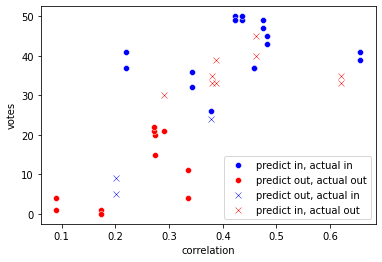

In [ ]:
corrs, votes, preds, actus = np.array(corrs), np.array(votes), np.array(preds), np.array(actus)

idx = np.array([preds[i]==True and actus[i]==True for i in range(len(preds))])
ax = sns.scatterplot(corrs[idx], votes[idx], color='blue', label='predict in, actual in')

idx = np.array([preds[i]==False and actus[i]==False for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], ax=ax, color='red', label='predict out, actual out')

idx = np.array([preds[i]==False and actus[i]==True for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], ax=ax, color='blue', marker='x', label='predict out, actual in')

idx = np.array([preds[i]==True and actus[i]==False for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], ax=ax, color='red', marker='x', label='predict in, actual out')

ax.set_xlabel('correlation')
ax.set_ylabel('votes')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Text(0, 0.5, 'probability')

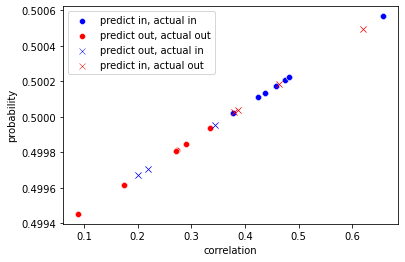

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(Cs=5).fit(np.expand_dims(corrs, 1), actus)
preds = clf.predict(np.expand_dims(corrs, 1))
func = clf.predict_proba(np.expand_dims(corrs, 1))[:, 1]

idx = np.array([preds[i]==True and actus[i]==True for i in range(len(preds))])
ax = sns.scatterplot(corrs[idx], func[idx], color='blue', label='predict in, actual in')

idx = np.array([preds[i]==False and actus[i]==False for i in range(len(preds))])
sns.scatterplot(corrs[idx], func[idx], ax=ax, color='red', label='predict out, actual out')

idx = np.array([preds[i]==False and actus[i]==True for i in range(len(preds))])
sns.scatterplot(corrs[idx], func[idx], ax=ax, color='blue', marker='x', label='predict out, actual in')

idx = np.array([preds[i]==True and actus[i]==False for i in range(len(preds))])
ax = sns.scatterplot(corrs[idx], func[idx], ax=ax, color='red', marker='x', label='predict in, actual out')

# sns.lineplot(corrs, func, ax=ax, linestyle=':')
ax.set_xlabel('correlation')
ax.set_ylabel('probability')